##Exothermic Continuous Stirred Tank Reactor example
The specific formulation and parameter values used in this section are taken from 
```
@inproceedings{
zhang2022smpl,
title={{SMPL}: Simulated Industrial Manufacturing and Process Control Learning Environments},
author={Mohan Zhang and Xiaozhou Wang and Benjamin Decardi-Nelson and Song Bo and An Zhang and Jinfeng Liu and Sile Tao and Jiayi Cheng and Xiaohong Liu and Dengdeng Yu and Matthew Poon and Animesh Garg},
booktitle={Thirty-sixth Conference on Neural Information Processing Systems Datasets and Benchmarks Track},
year={2022},
url={https://openreview.net/forum?id=TscdNx8udf5}
}

```

In [19]:
from ipsim import ProcessModel
from ipsim.models import ECSTR_S0
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

In [20]:
class PID:
    def __init__(self, Kis, steady_state=[0.8778252, 0.659], steady_action=[26.85, 0.1], min_action=[15.0, 0.05],
                 max_action=[35.0, 0.2]):
        self.Kis = Kis
        self.steady_state = steady_state
        self.steady_action = steady_action
        self.len_c = len(steady_action)
        self.min_action = min_action
        self.max_action = max_action

    def predict(self, state):
        state = [state[0], state[2]]
        action = []
        for i in range(self.len_c):
            a = self.Kis[i] * (state[i] - self.steady_state[i]) + self.steady_action[i]
            action.append(np.clip(a, self.min_action[i], self.max_action[i]))
        return np.array(action)

Let's create a process simulator. ECSTR_S0 already contains default parameters, but here we explicitly specify the observer and manipulator structures for easier future use.

In [21]:
def create_process(init_state):
    observer    = ProcessModel.make_common_objerver( [ ("SensorA", "cA")
                                                      , ("SensorT", "T")
                                                      , ("SensorH", "h") ])
    
    manipulator = ProcessModel.make_common_manipulator([("Coolant","T"), ("OutFlowControl", "q"), ])

    solver = lambda f, ts, x, u, p: solve_ivp(f, ts, x, args = (u, p, ), method='LSODA')
    process =  ECSTR_S0(solver=solver, observer=observer, manipulator=manipulator, dt=0.1, init_state=init_state)
    
    return process

In [22]:
def show(data):
    plt.figure(figsize=(12,3))

    plt.subplot(1, 5, 1)
    plt.plot(data["Tcs"], label="action=$T_c$")
    plt.xlabel('$t$, $min$')
    plt.ylabel('$T_c$, $C$')
    plt.grid()
    plt.tight_layout()
    plt.legend()

    plt.subplot(1, 5, 2)
    plt.plot(data["qs"], label="action=$q$")
    plt.xlabel('$t$, $min$')
    plt.ylabel('$q$')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    

    plt.subplot(1, 5, 3)
    plt.plot(data["cs"], label="$C_A$")
    plt.xlabel('$t$, $min$')
    plt.ylabel('$C_A$, $frac{mol}{L}$')
    plt.grid()
    plt.tight_layout()
    plt.legend()

    plt.subplot(1, 5, 4)
    plt.plot(data["Ts"], label="$T_s$")
    plt.xlabel('$t$, $min$')
    plt.ylabel('$T_s$, $C$')
    plt.grid()
    plt.tight_layout()
    plt.legend()

    plt.subplot(1, 5, 5)
    plt.plot(data["hs"], label="$h$")
    plt.xlabel('$t$, $min$')
    plt.ylabel('$h$, $m$')
    plt.grid()
    plt.tight_layout()

    plt.legend()
    plt.show()

Let's set up an initial state for the process simulator and control system and run some iterations.

In [23]:
process = create_process(init_state={ "cA": 0.1, "T" : 1, "h" : 0.1})
control =  PID(Kis=[100.0, 0.5], steady_state=[0.8778252, 0.659], steady_action=[26.85, 0.1], min_action=[15.0, 0.05], max_action=[35.0, 0.2])

cs  = []  # c_A
Ts  = []  # T
hs  = []  # h
Tcs = []  # Tc
qs =  []  # q_out
state = [0.1, 1, 0.1]
for _ in range(100):
    cs.append(state[0])
    Ts.append(state[1])
    hs.append(state[2])
    u = control.predict(state)
        
    Tcs.append(u[0])
    qs.append(u[1])
    state = process.step(action=u)

data = {"cs":cs, "Ts":Ts, "hs":hs, "Tcs": Tcs, "qs":qs}

Let's display the result

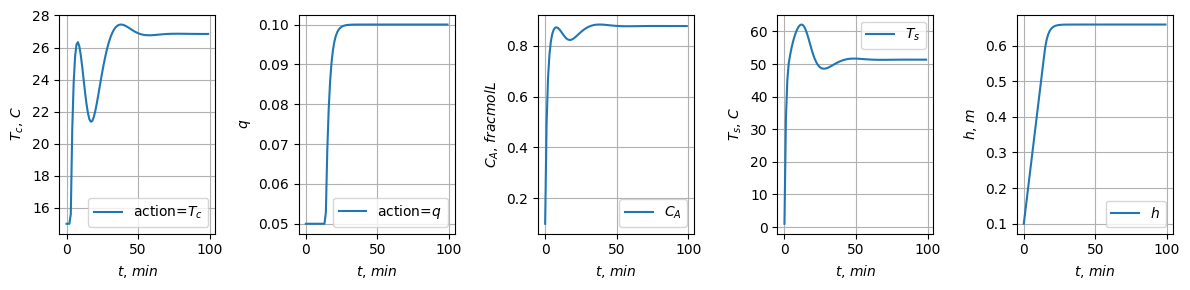

In [24]:
show(data)